In [1]:
#https://www.kaggle.com/akshayt19nayak/getting-started-image-processing-basics/notebook
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

stage1_test
stage1_train
stage1_train_labels.csv



In [2]:
#Importing the other necessary libraries
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

('Original Image Shape', (520, 696, 3))


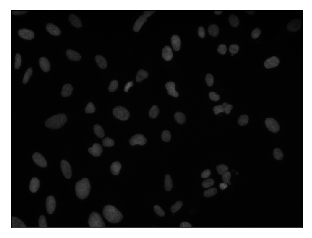

In [3]:
import cv2

training_paths = pathlib.Path('../input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]

bgrimg = cv2.imread(str(im_path))
plt.imshow(bgrimg)
plt.xticks([]) #To get rid of the x-ticks and y-ticks on the image axis
plt.yticks([])
print('Original Image Shape',bgrimg.shape)

('New Image Shape', (256, 256))


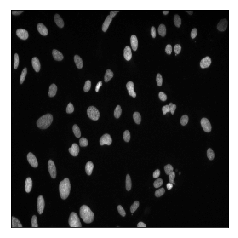

In [18]:
#To transfrom the colorspace from BGR to grayscale so as to make things simpler
grayimg = cv2.cvtColor(bgrimg,cv2.COLOR_BGR2GRAY)
desiredShape = (256,256)
grayimg = cv2.resize(grayimg,desiredShape)

plt.imshow(grayimg,cmap='gray') #cmap has been used as matplotlib uses some default colormap to plot grayscale images
plt.xticks([]) #To get rid of the x-ticks and y-ticks on the image axis
plt.yticks([])
print('New Image Shape',grayimg.shape)

Text(0.5,1,u'Distribution of intensity values')

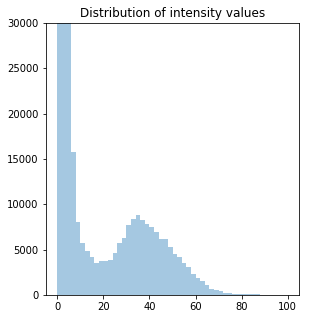

In [32]:
#Okay let's look at the distribution of the intensity values of all the pixels
plt.figure(figsize=(10,5))

#plt.subplot(1,2,1)
#sns.distplot(bgrimg.flatten(),kde=False)#This is to flatten the matrix and put the intensity values of all the pixels in one single row vector
#plt.title('Distribution of intensity values')

#To zoom in on the distribution and see if there is more than one prominent peak 
plt.subplot(1,2,2)
sns.distplot(bgrimg.flatten(),kde=False) 
plt.ylim(0,30000) 
plt.title('Distribution of intensity values')

In [22]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(grayimg)
print('The optimal seperation value is',thresh_val)

mask=np.where(grayimg>thresh_val,1,0)

('The optimal seperation value is', 21)


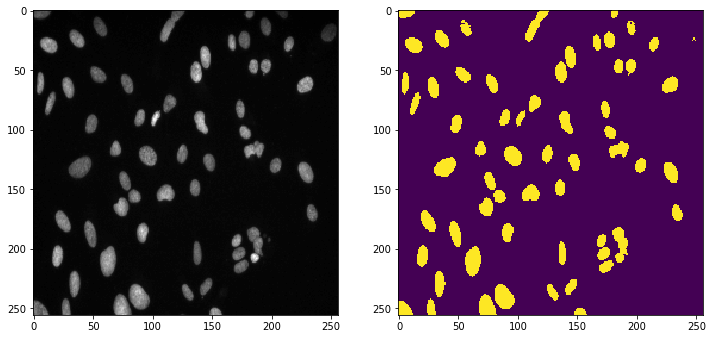

In [23]:
#plt.figure(figsize=(12,6))
#plt.subplot(1,2,1)
#plt.imshow(grayimg,cmap='gray')
#plt.title('Original Image')

#plt.subplot(1,2,2)
#maskimg = mask.copy()
#plt.imshow(maskimg, cmap='viridis')
#plt.title('Mask')

#To plot the original image and mask side by side
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(grayimg,cmap='gray')
axs[1].imshow(mask.copy())


In [24]:
from scipy import ndimage

labels,nlabels=ndimage.label(mask)
print('There are {} distinct nuclei in the mask.').format(nlabels)

There are 62 distinct nuclei in the mask.


In [25]:
#Since we need to create a seperate mask for every nucelus, let's store the masks in an iterable like a list 
label_array=[]
#We need to iterate from 1 as ndimage.label encodes every object starting from number 1
for i in range(1,nlabels+1):
    label_mask = np.where(labels==i,1,0)
    label_array.append(label_mask)

In [26]:
def rle(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

rle(label_mask)

'38142 3 38396 5 38651 6 38907 6 39163 6 39419 6 39675 6 39932 5 40188 5 40446 3 40704 1'

In [27]:
#Now defining a function that is applicable to all images
def basic(im_path):
    #Reading the image
    im_id=im_path.parts[-3] #To extract the image ID
    bgr = cv2.imread(str(im_path)) #Reading it in OpenCV
    gray = cv2.cvtColor(bgr,cv2.COLOR_BGR2GRAY) #Converting everything to grayscale from BGR
    desiredShape = (256,256)
    gray = cv2.resize(gray,desiredShape)

    #To remove the background
    thresh_val = threshold_otsu(gray) #Using Otsu's method to seperate the foreground objects from the background
    mask = np.where(gray > thresh_val, 1, 0) #Coding objects with intensity values higher than background as 1
    
    #Extracting connected objects
    test_rle=pd.DataFrame()
    labels, nlabels = ndimage.label(mask) #labels gives us the label of the different objects in every image starting from 1 and nlabels gives us the total number of objects in every image
    for i in range(1,nlabels+1): #Iterating through every object/label
        label_mask = np.where(labels==i,1,0) #Individual masks for every nucleus
        RLE = rle(label_mask) #RLE for every mask
        solution = pd.Series({'ImageId': im_id, 'EncodedPixels': RLE})
        test_rle = test_rle.append(solution, ignore_index=True)
    
    #Return the dataframe
    return(test_rle)


In [28]:
#Defining a function that takes a list of image paths (pathlib.Path objects), analyzes each and returns a submission ready DataFrame
def list_of_images(im_path_list):
    all_df = pd.DataFrame()
    for im_path in im_path_list: #We'll use this for the test images
        im_df = basic(im_path) #Creating one dataframe for every image 
        all_df = all_df.append(im_df, ignore_index=True) #Appending all these dataframes
    
    #Returing the submission ready dataframe
    return (all_df)

In [29]:
test_images = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
basic_solution = list_of_images(list(test_images))
basic_solution.to_csv('basic_solution.csv', index=None)
